### Connect to FRED API and Fetch Yield Curve Data
This section sets up the connection to the FRED (Federal Reserve Economic Data) API using your API key and pulls U.S. Treasury yield data for various maturities.

In [1]:
from fredapi import Fred

fred = Fred(api_key='5ae021feaa6c099d56b63c878fd8e21e')

# Example: Get 10-year treasury yield
yield_10y = fred.get_series('GS10')
yield_10y


1953-04-01    2.83
1953-05-01    3.05
1953-06-01    3.11
1953-07-01    2.93
1953-08-01    2.95
              ... 
2025-02-01    4.45
2025-03-01    4.28
2025-04-01    4.28
2025-05-01    4.42
2025-06-01    4.38
Length: 867, dtype: float64

In [2]:
!pip install dotenv

## Imports & Environment

### Connect to FRED API and Fetch Yield Curve Data
This section sets up the connection to the FRED (Federal Reserve Economic Data) API using your API key and pulls U.S. Treasury yield data for various maturities.

In [3]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px

# FRED API
from fredapi import Fred

# Load .env
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
fred_key = os.getenv("FRED_API_KEY")
if fred_key is None:
    raise ValueError("FRED_API_KEY not found. Did you create a .env file?")
fred = Fred(api_key=fred_key)


## Define Series & Helper to Fetch

### Organize Yield Data into a DataFrame
This function collects yield data for each treasury maturity and stores them as columns in a single DataFrame.

In [4]:
FRED_SERIES = {
    "1M": "DGS1MO",
    "3M": "DGS3MO",
    "6M": "DGS6MO",
    "1Y": "DGS1",
    "2Y": "DGS2",
    "3Y": "DGS3",
    "5Y": "DGS5",
    "7Y": "DGS7",
    "10Y": "DGS10",
    "20Y": "DGS20",
    "30Y": "DGS30",
}

def get_series_df(series_dict, start=None, end=None):
    frames = []
    for label, sid in series_dict.items():
        s = fred.get_series(sid, observation_start=start, observation_end=end)
        s = s.to_frame(name=label)
        frames.append(s)
    df = pd.concat(frames, axis=1)
    return df

# Pull from 1990 onward (plenty of curve history)
yc_raw = get_series_df(FRED_SERIES, start="1990-01-01")
yc_raw.tail()


,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2025-07-16,4.36,4.41,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01
2025-07-17,4.36,4.41,4.31,4.10,3.91,3.89,4.01,4.22,4.47,5.01,5.01
2025-07-18,4.35,4.40,4.30,4.08,3.88,3.84,3.96,4.18,4.44,4.99,5.00
2025-07-21,4.35,4.41,4.30,4.06,3.85,3.81,3.91,4.13,4.38,4.93,4.94
2025-07-22,4.37,4.41,4.30,4.05,3.83,3.77,3.88,4.09,4.35,4.90,4.90


## Clean Data (drop all-null rows, forward-fill occasional gaps)

### Clean and Align the Yield Data
Forward-fill and back-fill missing values to handle holidays and gaps in the data.

In [5]:
yc = yc_raw.copy()

# FRED returns float with NaNs where missing
# Drop rows where ALL maturities are NaN (holidays early history)
yc = yc.dropna(how="all")

# Forward-fill & back-fill small gaps
yc = yc.ffill().bfill()

# Ensure index is datetime
yc.index = pd.to_datetime(yc.index)

yc.head(), yc.tail()


(              1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
 1990-01-02  3.67  7.83  7.89  7.81  7.87  7.90  7.87  7.98  7.94  6.12  8.00
 1990-01-03  3.67  7.89  7.94  7.85  7.94  7.96  7.92  8.04  7.99  6.12  8.04
 1990-01-04  3.67  7.84  7.90  7.82  7.92  7.93  7.91  8.02  7.98  6.12  8.04
 1990-01-05  3.67  7.79  7.85  7.79  7.90  7.94  7.92  8.03  7.99  6.12  8.06
 1990-01-08  3.67  7.79  7.88  7.81  7.90  7.95  7.92  8.05  8.02  6.12  8.09,
               1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
 2025-07-16  4.36  4.41  4.31  4.08  3.88  3.86  3.99  4.21  4.46  5.01  5.01
 2025-07-17  4.36  4.41  4.31  4.10  3.91  3.89  4.01  4.22  4.47  5.01  5.01
 2025-07-18  4.35  4.40  4.30  4.08  3.88  3.84  3.96  4.18  4.44  4.99  5.00
 2025-07-21  4.35  4.41  4.30  4.06  3.85  3.81  3.91  4.13  4.38  4.93  4.94
 2025-07-22  4.37  4.41  4.30  4.05  3.83  3.77  3.88  4.09  4.35  4.90  4.90)

## Quick Visual: A Single-Day Curve & Time Series
Pick three dates to see how the curve bends in different macro regimes.

### Plot Yield Curves for Selected Historical Dates
This block visualizes how the yield curve looked on different macroeconomic events like the 2008 crisis, COVID-19 crash, etc.

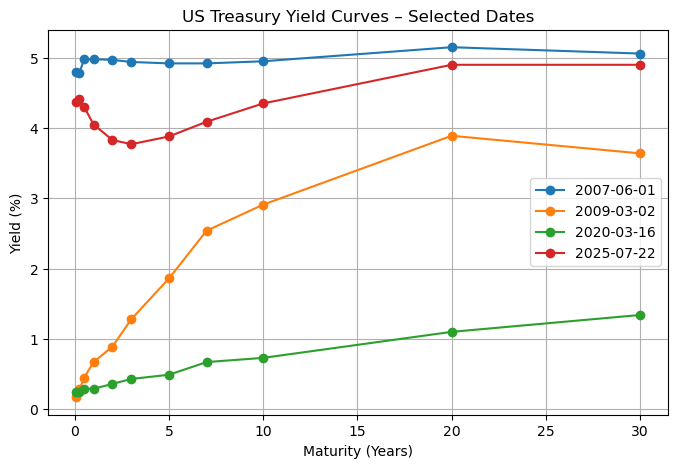

In [6]:
sample_dates = [
    "2007-06-01",  # Pre-Global Financial Crisis
    "2009-03-01",  # Crisis trough
    "2020-03-15",  # Pandemic shock
    yc.index.max().strftime("%Y-%m-%d"),  # Most recent
]

maturity_years = {
    "1M": 1/12,
    "3M": 3/12,
    "6M": 6/12,
    "1Y": 1,
    "2Y": 2,
    "3Y": 3,
    "5Y": 5,
    "7Y": 7,
    "10Y": 10,
    "20Y": 20,
    "30Y": 30,
}

tenors = np.array(list(maturity_years.values()))
labels = list(maturity_years.keys())

plt.figure(figsize=(8,5))
for d in sample_dates:
    if d not in yc.index:
        # use nearest available date
        d = yc.index[yc.index.get_indexer([d], method='nearest')[0]]
    row = yc.loc[d, labels]
    plt.plot(tenors, row.values, marker='o', label=str(d)[:10])
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("US Treasury Yield Curves – Selected Dates")
plt.legend()
plt.grid(True)
plt.show()


## 2s10s Spread Time Series

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

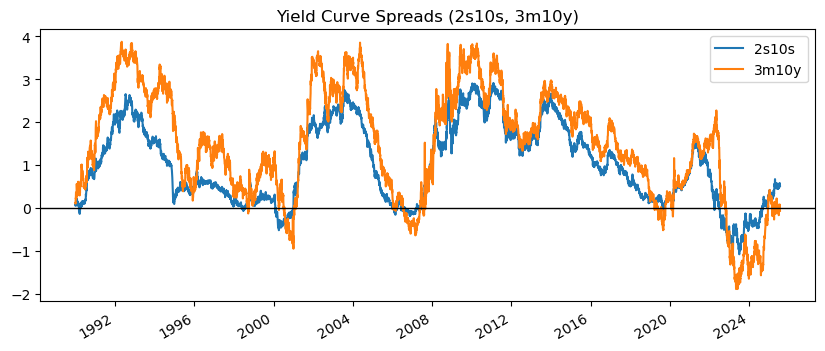

In [7]:
yc['2s10s'] = yc['10Y'] - yc['2Y']
yc['3m10y'] = yc['10Y'] - yc['3M']

yc[['2s10s','3m10y']].plot(figsize=(10,4), title="Yield Curve Spreads (2s10s, 3m10y)")
plt.axhline(0, color='k', linewidth=1)
plt.show()


You’ll see inversions when the line drops below zero — often recession signals.

## Step 1: Define the Nelson-Siegel Function

In [8]:
import numpy as np
from scipy.optimize import curve_fit

# Nelson-Siegel formula
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    tau = np.array(tau)
    term1 = (1 - np.exp(-lambd * tau)) / (lambd * tau)
    term2 = term1 - np.exp(-lambd * tau)
    return beta0 + beta1 * term1 + beta2 * term2


## Step 2: Pick a Date & Prepare the Data

In [9]:
# Pick a specific date you want to fit
date_to_fit = "2025-07-22"

# Use the same maturity map
maturity_years = {
    "1M": 1/12,
    "3M": 3/12,
    "6M": 6/12,
    "1Y": 1,
    "2Y": 2,
    "3Y": 3,
    "5Y": 5,
    "7Y": 7,
    "10Y": 10,
    "20Y": 20,
    "30Y": 30,
}

labels = list(maturity_years.keys())
taus = list(maturity_years.values())
# Get yields for the date
yields = yc.loc[date_to_fit, labels].values



## Step 3: Fit the Model Using curve_fit

In [10]:
# Initial guess for [beta0, beta1, beta2, lambda]
initial_guess = [4.0, -1.0, 1.0, 0.5]

# Use curve fitting to find best parameters
params, _ = curve_fit(nelson_siegel, taus, yields, p0=initial_guess)

# Print estimated parameters
beta0, beta1, beta2, lambd = params
print(f"β₀ (Level):     {beta0:.3f}")
print(f"β₁ (Slope):     {beta1:.3f}")
print(f"β₂ (Curvature): {beta2:.3f}")
print(f"λ (Decay):      {lambd:.3f}")


β₀ (Level):     5.318
β₁ (Slope):     -0.805
β₂ (Curvature): -3.751
λ (Decay):      0.445


## Step 4: Plot Actual vs Fitted Curve

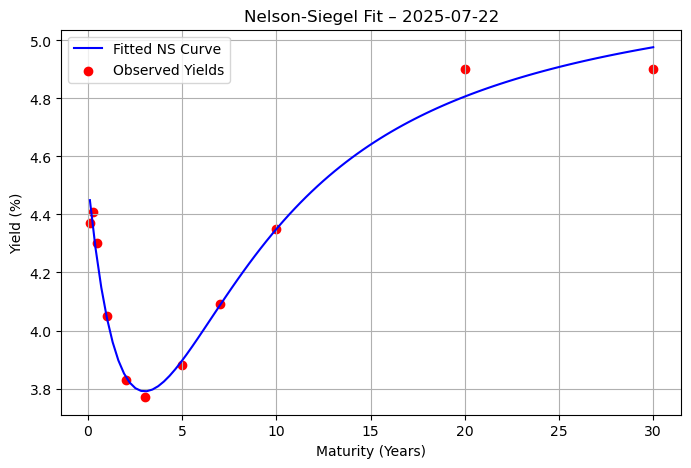

In [11]:
# Create fine grid for smooth curve
tau_fine = np.linspace(0.1, 30, 100)
fitted_yields = nelson_siegel(tau_fine, *params)

# Plot
plt.figure(figsize=(8,5))
plt.plot(tau_fine, fitted_yields, label="Fitted NS Curve", color='blue')
plt.scatter(taus, yields, color='red', label="Observed Yields")
plt.title(f"Nelson-Siegel Fit – {date_to_fit}")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()


### Now I'm doing full time-series of Nelson-Siegel parameters across all dates in the dataset using a loop-based approach.

## Step 1: Setup

In [12]:
!pip install tqdm ipywidgets


In [13]:
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import warnings

# Prepare data
labels = list(maturity_years.keys())
taus = np.array(list(maturity_years.values()))

# Optional: fix lambda to simplify fitting
FIX_LAMBDA = 0.73  # You can tune or set to None

# Initialize result storage
param_records = []

# Loop through dates (with progress bar)
warnings.filterwarnings("ignore")  # to suppress minor curve_fit warnings
for date, row in tqdm(yc[labels].iterrows(), total=len(yc)):
    yields = row.values

    if np.any(np.isnan(yields)):
        continue  # skip days with missing data

    try:
        if FIX_LAMBDA:
            # Define a version with fixed lambda
            def ns_fixed(tau, beta0, beta1, beta2):
                term1 = (1 - np.exp(-FIX_LAMBDA * tau)) / (FIX_LAMBDA * tau)
                term2 = term1 - np.exp(-FIX_LAMBDA * tau)
                return beta0 + beta1 * term1 + beta2 * term2

            popt, _ = curve_fit(ns_fixed, taus, yields, p0=[4.0, -1.0, 1.0])
            beta0, beta1, beta2 = popt
            lambd = FIX_LAMBDA
        else:
            popt, _ = curve_fit(nelson_siegel, taus, yields, p0=[4.0, -1.0, 1.0, 0.5])
            beta0, beta1, beta2, lambd = popt

        # Save result
        param_records.append({
            "date": date,
            "beta0": beta0,
            "beta1": beta1,
            "beta2": beta2,
            "lambda": lambd
        })

    except RuntimeError:
        # Fitting failed
        continue


  0%|          | 0/8894 [00:00<?, ?it/s]

## Step 2: Convert to DataFrame

In [14]:
df_params = pd.DataFrame(param_records).set_index("date")
df_params = df_params.sort_index()
df_params.head()


,beta0,beta1,beta2,lambda
date,,,,
1990-01-02,6.756371,-1.168262,7.143197,0.73
1990-01-03,6.773561,-1.166514,7.304507,0.73
1990-01-04,6.778464,-1.195881,7.238800,0.73
1990-01-05,6.798147,-1.251192,7.224063,0.73
1990-01-08,6.817980,-1.261225,7.208480,0.73


## Step 3: Plot Time Series of Parameters

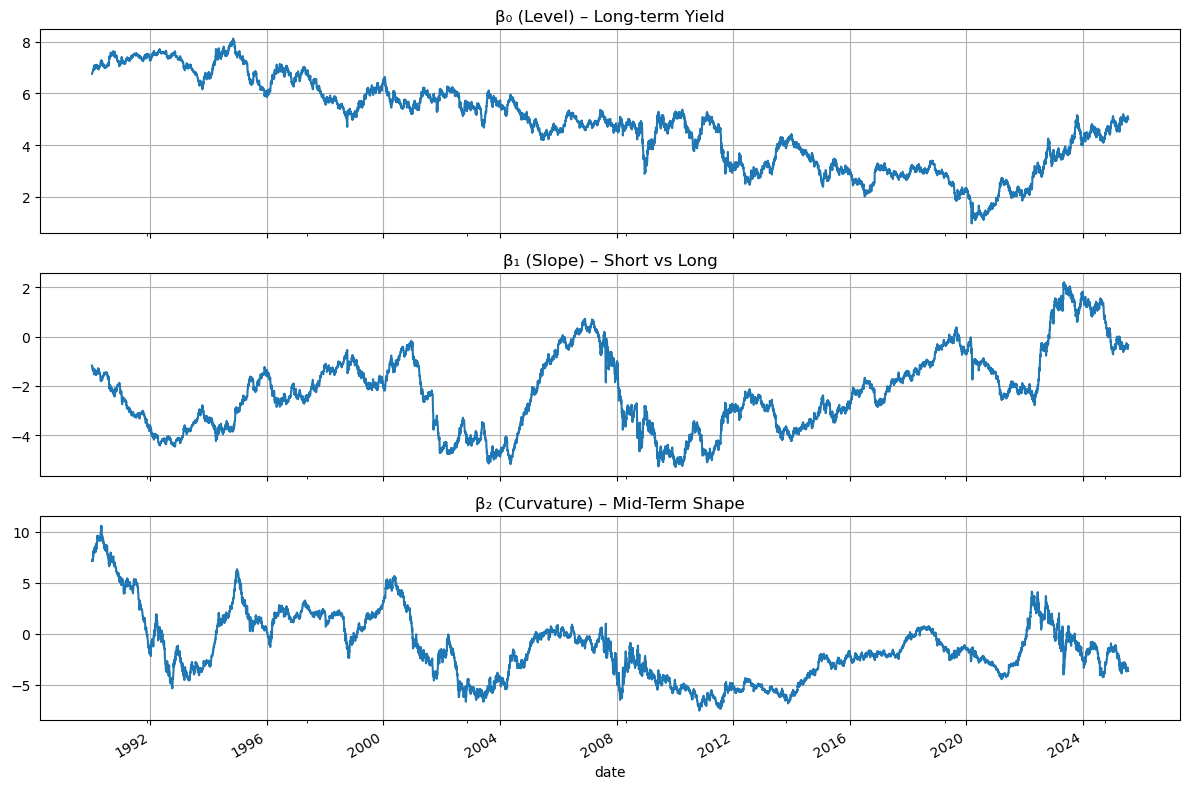

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

df_params["beta0"].plot(ax=ax[0], title="β₀ (Level) – Long-term Yield")
ax[0].grid(True)

df_params["beta1"].plot(ax=ax[1], title="β₁ (Slope) – Short vs Long")
ax[1].grid(True)

df_params["beta2"].plot(ax=ax[2], title="β₂ (Curvature) – Mid-Term Shape")
ax[2].grid(True)

plt.tight_layout()
plt.show()


Using the Nelson-Siegel model, I decomposed the U.S. Treasury yield curve from 1990 to 2025.
The β₀ trend shows secular declines in long-term rates post-2000, with sharp rebounds during inflation cycles.
β₁ effectively captures recessions, inverting pre-2001, 2008, and 2023.
β₂ spikes during crises reflect investor uncertainty in medium-term rate paths.
These parameters not only smoothly approximate the curve but also carry deep economic and trading signal value.

# Now I'm gonna implement the Dynamic Nelson-Siegel

## Step 1: Imports + Setup

In [16]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt

# Fix lambda as before
FIX_LAMBDA = 0.73

# Convert maturities to numeric vector
taus = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
maturity_labels = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]


## Step 2: Nelson-Siegel Design Matrix Function

In [17]:
def ns_design_matrix(taus, lambd):
    H = []
    for tau in taus:
        if tau == 0:
            H.append([1.0, 0.0, 0.0])
        else:
            t1 = (1 - np.exp(-lambd * tau)) / (lambd * tau)
            t2 = t1 - np.exp(-lambd * tau)
            H.append([1.0, t1, t2])
    return np.array(H)


## Step 3: Kalman Filter Setup

In [18]:
# Create design matrix once (same every day)
H = ns_design_matrix(taus, FIX_LAMBDA)

kf = KalmanFilter(dim_x=3, dim_z=len(taus))
kf.x = np.array([3.0, -1.0, 1.0])  # initial [β0, β1, β2]
kf.F = np.eye(3)                   # β follows random walk
kf.H = H                           # design matrix (same daily)
kf.P *= 1.0                        # initial uncertainty
kf.R *= 0.1                        # observation noise
kf.Q = Q_discrete_white_noise(dim=3, dt=1, var=0.01)  # process noise


## Step 4: Run Kalman Filter on Yield Curve Data

In [19]:
# Only use days with all maturities available
yc_kf = yc[maturity_labels].dropna()

filtered_betas = []

for date, row in yc_kf.iterrows():
    z = row.values  # observed yields
    kf.predict()
    kf.update(z)
    filtered_betas.append([date, *kf.x])

df_kf = pd.DataFrame(filtered_betas, columns=["date", "beta0", "beta1", "beta2"]).set_index("date")


## Step 5: Plot the Smoothed βs Over Time

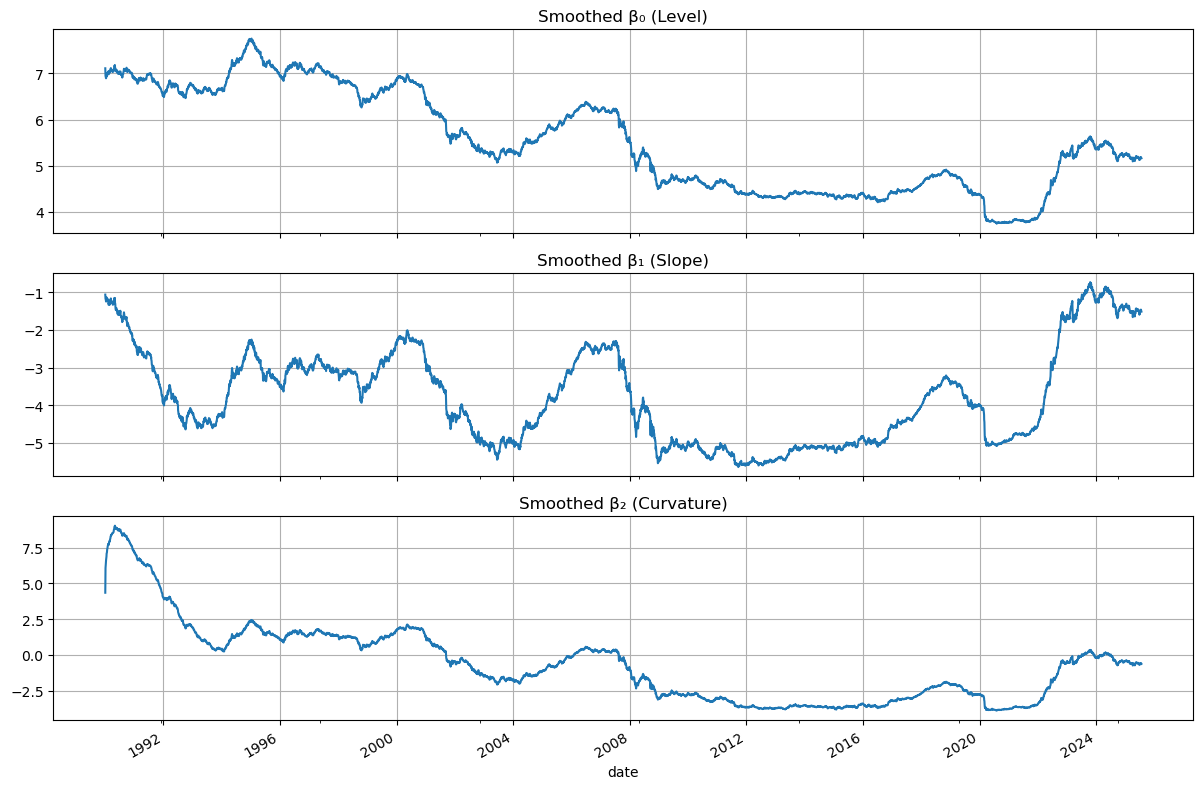

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

df_kf["beta0"].plot(ax=ax[0], title="Smoothed β₀ (Level)")
df_kf["beta1"].plot(ax=ax[1], title="Smoothed β₁ (Slope)")
df_kf["beta2"].plot(ax=ax[2], title="Smoothed β₂ (Curvature)")

for a in ax: a.grid(True)
plt.tight_layout()
plt.show()


# Let me use the Kalman-filtered β₁ (slope) to try and predict & trade the 2s10s yield curve spread

### Step 1: Align Kalman-filtered β₁ with 2s10s Spread

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

In [21]:
# First, compute the 2s10s spread from your yield data
yc_kf["2s10s"] = yc_kf["10Y"] - yc_kf["2Y"]

# Merge with β₁
df_trade = df_kf[["beta1"]].copy()
df_trade["2s10s"] = yc_kf["2s10s"]
df_trade = df_trade.dropna()


### Step 2: Create Trading Signal from β₁ Slope (its 1st derivative)

In [22]:
# Create signal: 1 if beta1 is rising, -1 if falling
df_trade["beta1_diff"] = df_trade["beta1"].diff()
df_trade["signal"] = np.sign(df_trade["beta1_diff"])

# (Optional) smooth the signal with rolling mean
df_trade["signal"] = df_trade["signal"].rolling(3).mean().fillna(0)


### Step 3: Simulate Strategy P&L

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

In [23]:
# Calculate change in 2s10s (this is the PnL of a 2s10s trade)
df_trade["spread_change"] = df_trade["2s10s"].diff()

# PnL = signal * change in spread
df_trade["strategy_pnl"] = df_trade["signal"].shift(1) * df_trade["spread_change"]

# Cumulative return
df_trade["cumulative_pnl"] = df_trade["strategy_pnl"].cumsum()


### Step 4: Plot the Signal and Cumulative PnL

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

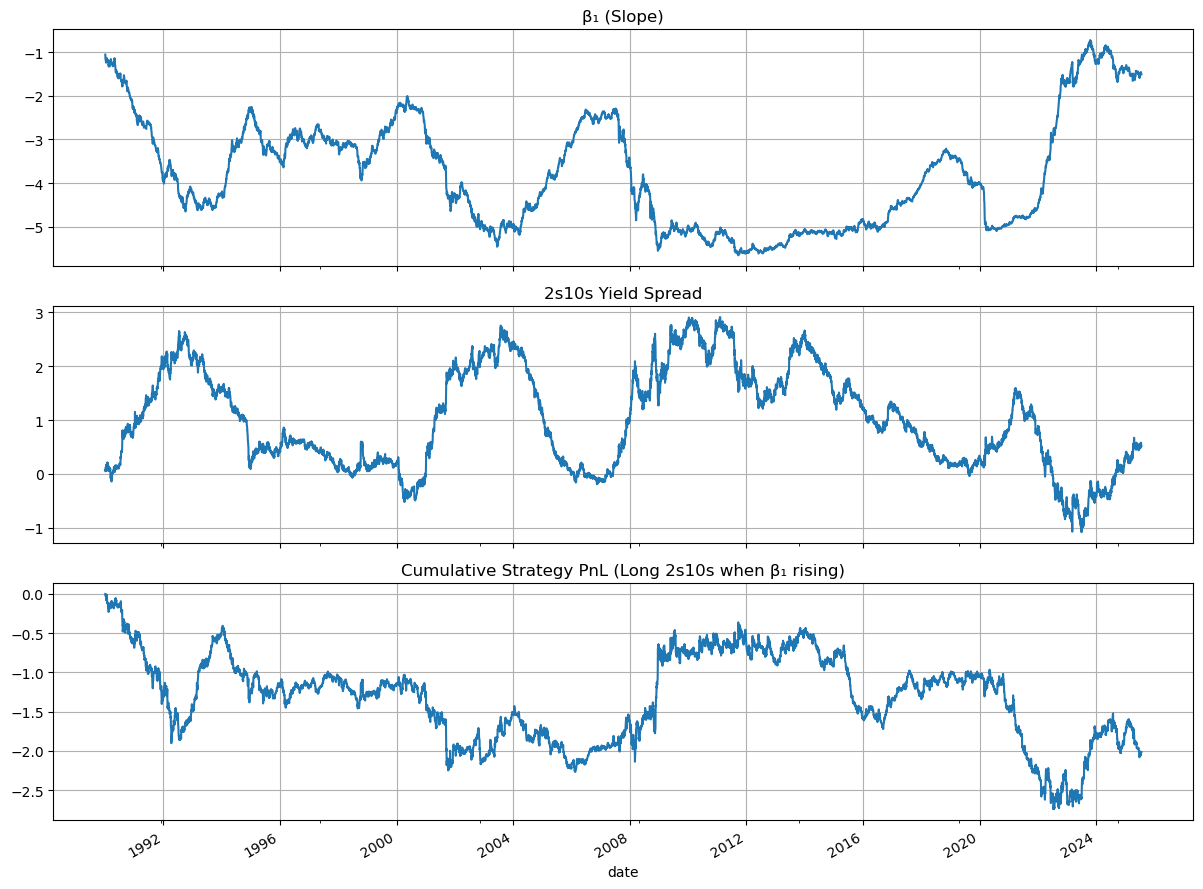

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

df_trade["beta1"].plot(ax=ax[0], title="β₁ (Slope)")
ax[0].grid(True)

df_trade["2s10s"].plot(ax=ax[1], title="2s10s Yield Spread")
ax[1].grid(True)

df_trade["cumulative_pnl"].plot(ax=ax[2], title="Cumulative Strategy PnL (Long 2s10s when β₁ rising)")
ax[2].grid(True)

plt.tight_layout()
plt.show()


Our signals are not that strong and mostly negative and stagnant.

# PART A: Optimize the Trading Signal (β₁ Slope-Based)

### Step 1: Apply a Threshold

In [25]:
# Apply a threshold: signal = 1 only when beta1 is rising significantly
threshold = 0.03
df_trade["signal"] = np.where(df_trade["beta1_diff"] > threshold, 1,
                              np.where(df_trade["beta1_diff"] < -threshold, -1, 0))



### Step 2: Recalculate Strategy PnL

In [26]:
df_trade["strategy_pnl"] = df_trade["signal"].shift(1) * df_trade["spread_change"]
df_trade["cumulative_pnl"] = df_trade["strategy_pnl"].cumsum()


### Step 3: Re-Plot Cumulative PnL

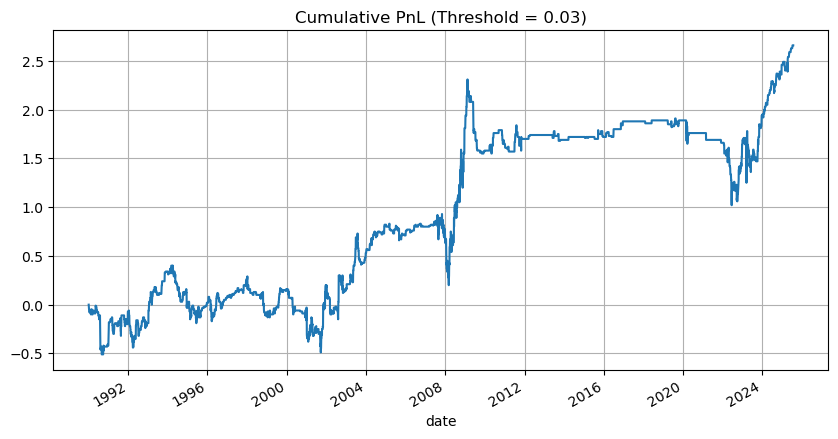

In [27]:
df_trade["cumulative_pnl"].plot(figsize=(10, 5), title=f"Cumulative PnL (Threshold = {threshold})", grid=True)
plt.show()


# Now I'll try Forecasting 2s10s Using β (Build predictive model)

### Step 1: Prepare the lagged data (for 1-Lag Linear Regression)

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

In [28]:
df_model = df_trade[["2s10s", "beta1"]].copy()
df_model["beta1_lag1"] = df_model["beta1"].shift(1)
df_model = df_model.dropna()


### Step 2: Fit Linear Regression Model

In [29]:
!pip install statsmodels

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

In [30]:
import statsmodels.api as sm

X = df_model["beta1_lag1"]
y = df_model["2s10s"]

# Add constant term for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  2s10s   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 1.385e+04
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:38:17   Log-Likelihood:                -7700.3
No. Observations:                8893   AIC:                         1.540e+04
Df Residuals:                    8891   BIC:                         1.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1372      0.019    -59.011      0.0

### Step 3: Plot Actual vs Predicted

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

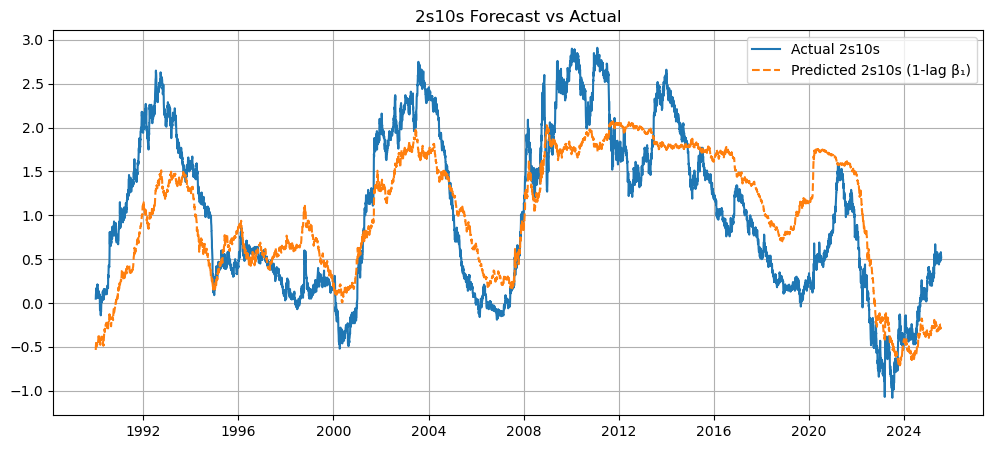

In [31]:
df_model["predicted_spread"] = model.predict(X)

plt.figure(figsize=(12,5))
plt.plot(df_model.index, df_model["2s10s"], label="Actual 2s10s")
plt.plot(df_model.index, df_model["predicted_spread"], label="Predicted 2s10s (1-lag β₁)", linestyle='--')
plt.title("2s10s Forecast vs Actual")
plt.legend()
plt.grid()
plt.show()

# Now, trying 3 lags of β₁


In [32]:
!pip install scikit-learn

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

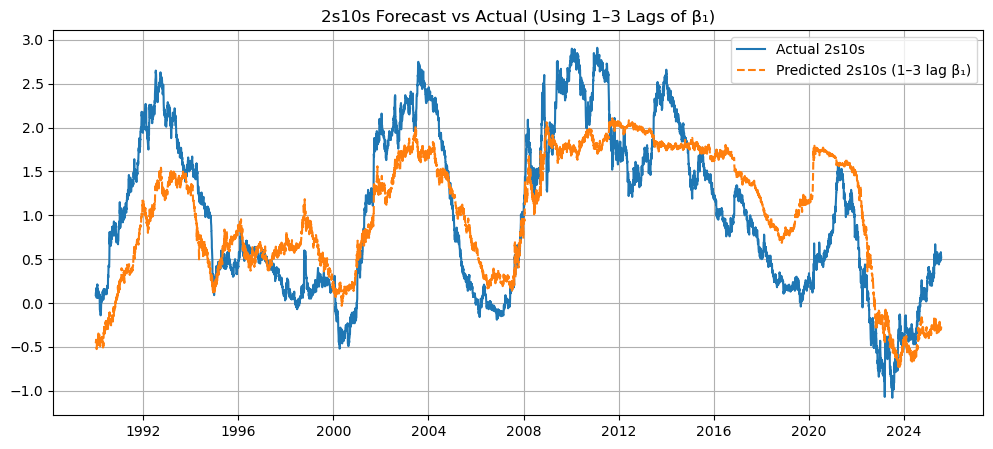

In [33]:
# Create lag features
df_model = df_trade[["2s10s", "beta1"]].copy()
df_model["beta1_lag1"] = df_model["beta1"].shift(1)
df_model["beta1_lag2"] = df_model["beta1"].shift(2)
df_model["beta1_lag3"] = df_model["beta1"].shift(3)

# Drop rows with NaNs (due to lagging)
df_model = df_model.dropna()

# Regression model with 3 lags
from sklearn.linear_model import LinearRegression

X = df_model[["beta1_lag1", "beta1_lag2", "beta1_lag3"]]
y = df_model["2s10s"]
model = LinearRegression()
model.fit(X, y)

# Predict and plot
df_model["2s10s_pred"] = model.predict(X)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model["2s10s"], label="Actual 2s10s")
plt.plot(df_model.index, df_model["2s10s_pred"], label="Predicted 2s10s (1–3 lag β₁)", linestyle="--")
plt.title("2s10s Forecast vs Actual (Using 1–3 Lags of β₁)")
plt.legend()
plt.grid(True)
plt.show()


# Now I'll try to get the Model Evaluation Metrics

#### We'll compute three key metrics:

* R² Score → How well does your model explain variation in actual 2s10s?

* MSE (Mean Squared Error) → Average squared error between actual and predicted.

* Correlation Coefficient (Pearson's r) → Direction and strength of linear relationship.

### Compute 2s10s and 3m10y Spreads
These spreads are commonly used to monitor yield curve steepness and detect potential recession signals.

In [34]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Step 1: Get the values
actual = df_model["2s10s"]
predicted = df_model["2s10s_pred"]

# Step 2: Compute evaluation metrics
r2 = r2_score(actual, predicted)
mse = mean_squared_error(actual, predicted)
correlation = np.corrcoef(actual, predicted)[0, 1]

# Step 3: Print them nicely
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Correlation Coefficient: {correlation:.4f}")


R² Score: 0.6094
Mean Squared Error (MSE): 0.3305
Correlation Coefficient: 0.7807
